In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml
import sys
sys.path.insert(0, '../')
import ccob_utils as u
import ccob_beam as b
import pickle
%load_ext autoreload
%autoreload 2 

In [2]:
config_file_beam = '../ccob_beam_recons_config.yaml'
config = u.load_ccob_config(config_file_beam)

In [3]:
#ref_amp_list = [1,4,7,12,13]
ref_amp_list = [13]
for ref_amp in ref_amp_list:
    beam = b.CcobBeam(config)
    beam.recons(ref_slot='11', ref_amp=ref_amp, ref_pix_x=1000,ref_pix_y=256)
    beam.make_image()
    beam.find_max()
    filename = beam.config['led_name']+'_beam_slot'+beam.properties['ref_slot']+'_amp'+str(ref_amp)+\
               '_refx'+str(beam.properties['ref_pix_x'])+'_refy'+str(beam.properties['ref_pix_y'])+'.pkl'
    print('Printing to ',filename)
    beam.save(os.path.join(beam.config['tmp_dir'],filename))
  

red
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/red/11*red*********
Printing to  red_beam_slot11_amp13_refx1000_refy256.pkl


In [4]:
filename = 'red_beam_slot11_amp13_refx1000_refy256.pkl'
my_beam = pickle.load(open(os.path.join(beam.config['tmp_dir'],filename),'rb'))
my_beam.make_image(ncols=3000,nrows=3000)
my_beam.find_max()
print(my_beam.properties)

{'ref_slot': '11', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 3000, 'nrows': 3000, 'max_xccob': 286.52484161387127, 'max_yccob': 199.07902634211405, 'max_xarg': 1490, 'max_yarg': 1741}


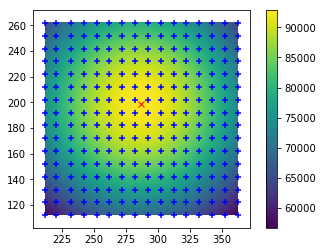

In [135]:
%matplotlib inline
my_beam.plot()

In [136]:
my_file = '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/00_CCOB_red_x295.0_y195.0_0000_20180420200617.fits.fz'
config_file_data = '../ccob_config_RTM-006.yaml'
config = u.load_ccob_config(config_file_data)
print(config)

{'led_name': 'red', 'path': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red', 'tmp_dir': '/home/combet/tmp_new/', 'eo_data_path': '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/collect_raft_results/v0/38904', 'xpos': '295.0', 'ypos': '195.0', 'current': '*', 'exp_time': '*', 'slot': '*'}


In [137]:
slot_names=['00','01','02','10','11','12','20','21','22']

slot='11'
file_list=sorted(u.find_files(config, slot=slot))
print(file_list)

mean_slot_file = slot+'_mean_ccob_image.fits'
imutils.fits_mean_file(file_list, os.path.join(config['tmp_dir'],mean_slot_file))


#fits_file = file_list[0]
fits_file = os.path.join(config['tmp_dir'],mean_slot_file)
gains_dict={}
ccd_dict={}

bias_frames = glob.glob(os.path.join(config['path'], slot+'_bias*'))
mean_bias_file = slot+'_mean_bias_image_RTM-006_new.fits'
#imutils.fits_mean_file(bias_frames, os.path.join(config['tmp_dir'],mean_bias_file))
ccd_dict = sensorTest.MaskedCCD(fits_file, bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(ccd_dict.md('LSST_NUM')))
gains_dict = u.gains(eotest_results_file)

/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11*red*****295.0*195.0*
['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200541.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200550.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200559.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200608.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200617.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200626.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200635.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_2018042020064

In [138]:
mosaic, amp_coord = u.make_ccd_2d_array(fits_file, gains=gains_dict)
ref_pix = u.pix_coord_in_mosaic(amp_coord, ref_amp_list[0], 256, 1000)

xpos_ccob = 295.0
ypos_ccob = 195.0
delta_x = ypos_ccob - my_beam.properties['max_yccob']
delta_y = xpos_ccob - my_beam.properties['max_xccob']
delta_x_pix = int(delta_x/0.01)
delta_y_pix = int(delta_y/0.01)

print('deplacement in mm: dx=%0.2f dy=%0.2f'%(delta_x, delta_y))
print('deplacement in pixels: dx=%i dy=%i'%(delta_x_pix, delta_y_pix))

geom_center_pos=(ref_pix[0]+delta_x_pix, ref_pix[1]+delta_y_pix)
geom_center_pos

deplacement in mm: dx=-4.08 dy=8.48
deplacement in pixels: dx=-407 dy=847


(1897, 1847)

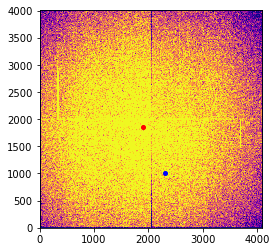

In [139]:
plt.imshow(mosaic, origin='lower', vmin=63000, vmax=65000, cmap='plasma')
plt.plot([ref_pix[0]], [ref_pix[1]], marker='o', markersize=4, color='blue')
plt.plot([geom_center_pos[0]], [geom_center_pos[1]], marker='o', markersize=4, color='red')

In [140]:
# distance from beam center to ccd edges in mm
dist_to_left = geom_center_pos[0]*0.01
dist_to_bottom = geom_center_pos[1]*0.01
dist_to_right = (mosaic.shape[1] - geom_center_pos[0])*0.01
dist_to_top = (mosaic.shape[0] - geom_center_pos[1])*0.01
print(dist_to_left,dist_to_bottom,dist_to_right,dist_to_top)
print(dist_to_left+dist_to_right, dist_to_bottom+dist_to_top)

18.97 18.47 21.990000000000002 21.57
40.96 40.04


In [141]:
bbox=(my_beam.properties['max_xccob']-dist_to_left,
      my_beam.properties['max_xccob']+dist_to_right,
      my_beam.properties['max_yccob']-dist_to_bottom,
      my_beam.properties['max_yccob']+dist_to_top)

In [142]:
xarr2 = np.linspace(bbox[0],bbox[1],mosaic.shape[1])
yarr2 = np.linspace(bbox[2],bbox[3],mosaic.shape[0])
tmp = my_beam.beam_image['f_interp'](xarr2, yarr2)

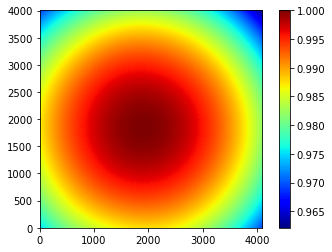

In [143]:
plt.imshow(tmp/np.max(tmp.flatten()), origin='lower',cmap='jet')
plt.colorbar()

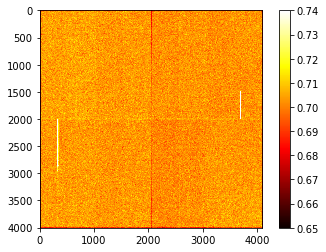

In [144]:
res=mosaic/tmp
plt.imshow(res, vmin=0.65, vmax=0.74,cmap='hot')
plt.colorbar()

In [145]:
config = u.load_ccob_config(config_file_beam)
config

{'led_name': 'red',
 'path': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob',
 'tmp_dir': '/home/combet/tmp_new/',
 'eo_data_path': '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/collect_raft_results/v0/38904',
 'current': '*',
 'exp_time': '*',
 'xpos': '*',
 'ypos': '*',
 'slot': '*'}

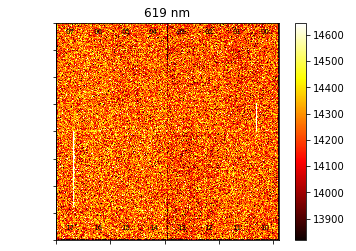

In [166]:
f='/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/qe_raft_acq/v0/38892/S11/E2V-CCD250-131-Dev_lambda_flat_0620_5867D_20180417041731.fits'
sensorTest.plot_flat(f, gains=gains_dict)

In [147]:
slac_flat, dumm = u.make_ccd_2d_array(f, gains=gains_dict)

In [148]:
res.shape

(4004, 4096)

In [149]:
slac_flat.shape

(4004, 4096)

0.038630889536


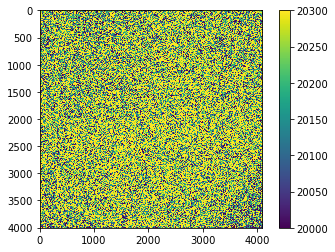

In [157]:
plt.imshow(slac_flat/res, vmin=20000, vmax=20300)
plt.colorbar()

print(np.std(slac_flat/res)/np.mean(slac_flat/res))

In [158]:
import scipy.ndimage as sc

In [164]:
new = sc.uniform_filter(slac_flat/res, 10)

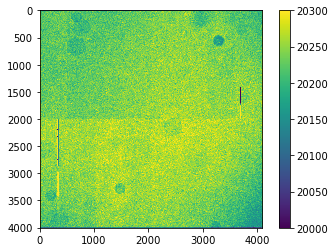

In [165]:
plt.imshow(new, vmin=20000, vmax=20300)
plt.colorbar()


### CCOB QE anlysis using dedicated class

In [3]:
import sys
sys.path.insert(0, '../')
import ccob_qe_analysis as qe
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config_file_beam = '../ccob_beam_recons_config.yaml'
config_file_data = '../ccob_config_RTM-006.yaml'
QE = qe.CcobQE(config_file_beam, config_file_data)

In [87]:
#QE.make_ccob_beam()
QE.load_ccob_beam('/home/combet/tmp_new/red_beam_slot11_amp13_refx1000_refy256.pkl')
#QE.load_ccob_beam('/home/combet/tmp_new/nm750_beam_slot11_amp13_refx1000_refy256.pkl')

../ccob_qe_analysis.py:48: ResourceWarning: unclosed file <_io.BufferedReader name='/home/combet/tmp_new/red_beam_slot11_amp13_refx1000_refy256.pkl'>
  by the CCOB


In [81]:
QE.beam.properties

{'ref_slot': '11',
 'ref_amp': 13,
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'ncols': 300,
 'nrows': 300,
 'max_xccob': 285.74581939799333,
 'max_yccob': 198.78929765886289,
 'max_xarg': 147,
 'max_yarg': 173}

In [88]:
ccd = QE.load_ccd(led_name='red')

../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_config_RTM-006.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))


/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11*red*****295.0*195.0*


../ccob_qe_analysis.py:81: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_new/11_mean_ccob_image.fits' mode='rb' closefd=True>
  


In [8]:
QE.ccd['amp_coord']

{(0, 0): {'amp': 1,
  'segment': 'SEGMENT10',
  'xmin': 3584,
  'xmax': 4096,
  'ymin': 2002,
  'ymax': 4004,
  'flipx': False,
  'flipy': True,
  'detsec': {'xmin': 512, 'xmax': 1, 'ymin': 1, 'ymax': 2002},
  'datasec': {'xmin': 11, 'xmax': 522, 'ymin': 1, 'ymax': 2002}},
 (1, 0): {'amp': 2,
  'segment': 'SEGMENT11',
  'xmin': 3072,
  'xmax': 3584,
  'ymin': 2002,
  'ymax': 4004,
  'flipx': False,
  'flipy': True,
  'detsec': {'xmin': 1024, 'xmax': 513, 'ymin': 1, 'ymax': 2002},
  'datasec': {'xmin': 11, 'xmax': 522, 'ymin': 1, 'ymax': 2002}},
 (2, 0): {'amp': 3,
  'segment': 'SEGMENT12',
  'xmin': 2560,
  'xmax': 3072,
  'ymin': 2002,
  'ymax': 4004,
  'flipx': False,
  'flipy': True,
  'detsec': {'xmin': 1536, 'xmax': 1025, 'ymin': 1, 'ymax': 2002},
  'datasec': {'xmin': 11, 'xmax': 522, 'ymin': 1, 'ymax': 2002}},
 (3, 0): {'amp': 4,
  'segment': 'SEGMENT13',
  'xmin': 2048,
  'xmax': 2560,
  'ymin': 2002,
  'ymax': 4004,
  'flipx': False,
  'flipy': True,
  'detsec': {'xmin': 2048,

In [89]:
qe = QE.compute_QE()

deplacement in mm: dx=-4.29 dy=8.25
deplacement in pixels: dx=-429 dy=825


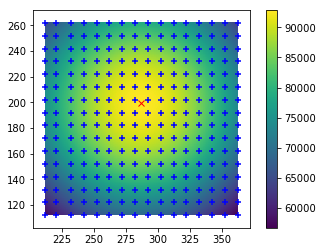

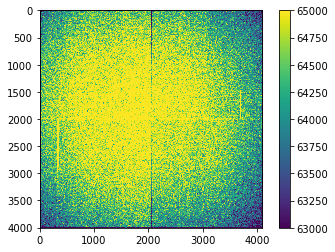

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
QE.beam.plot()
plt.imshow(QE.ccd['mosaic'], vmin=63000, vmax=65000)
plt.colorbar()

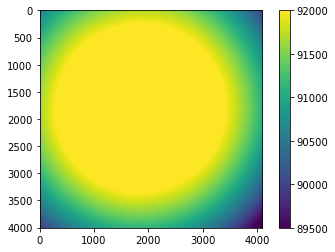

In [91]:
plt.imshow(QE.beam_image, vmin=89500, vmax=92000)
plt.colorbar()

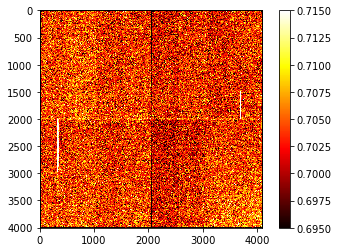

In [92]:
plt.imshow(QE.QE, vmin=0.695, vmax=0.715, cmap='hot')
plt.colorbar()

In [9]:
import astropy.io.fits as fits

In [62]:
print(QE.QE.shape)    
    
template_file = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/qe_raft_acq/v0/38892/S11/E2V-CCD250-131-Dev_lambda_flat_0620_5867D_20180417041731.fits'
  
QE.make_fits('test.fits', template_file)

(4004, 4096)


0.703446
0.70349
0.701759
0.700778
0.702981
0.702397
0.703343
0.70254
0.702813
0.703807
0.702231
0.702771
0.701412
0.702303
0.701676
0.70231


In [52]:
QE.QE

array([[ 0.15948948,  0.34842715,  0.38726316, ...,  0.42627467,
         0.38671146,  0.19221958],
       [ 0.16969498,  0.35821062,  0.39930653, ...,  0.43430922,
         0.38921629,  0.1928116 ],
       [ 0.19067468,  0.39678228,  0.44507804, ...,  0.46755418,
         0.42009123,  0.21263668],
       ..., 
       [ 0.18863299,  0.39254477,  0.43075741, ...,  0.43511361,
         0.39503656,  0.18847552],
       [ 0.1802847 ,  0.37541837,  0.41897902, ...,  0.41543596,
         0.37305543,  0.1807055 ],
       [ 0.18957997,  0.4017868 ,  0.44156256, ...,  0.42775762,
         0.38815223,  0.17827006]])

In [56]:
import astropy.io.fits as fits
foo = fits.open('test.fits')

/lsst/dh/software/centos7-gcc48/stack/v16_py3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='test.fits' mode='rb' closefd=True>
  


In [58]:
#ccd_dict = sensorTest.MaskedCCD('/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/00_CCOB_red_x295.0_y195.0_0000_20180420200617.fits.fz')
ccd_dict = sensorTest.MaskedCCD('test.fits')

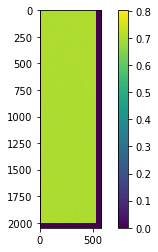

In [60]:
plt.imshow(ccd_dict[2].getImage().getArray()),
plt.colorbar()

In [1]:
sensorTest.plot_flat('test.fits')

NameError: name 'sensorTest' is not defined

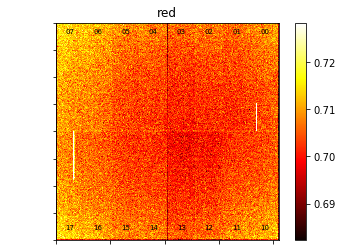

In [6]:
%matplotlib inline
sensorTest.plot_flat('/home/combet/tmp_new/11_CCOB_QE_nm850.fits', title='red', nsig=5)


## ===================== all =========================

In [3]:
import sys
sys.path.insert(0, '../')
import ccob_qe_analysis as qe
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config_file_beam = '../ccob_beam_recons_config.yaml'
config_file_data = '../ccob_config_RTM-006.yaml'


In [5]:
xpos = [253.0, 253.0, 253.0, 295.0, 295.0, 295.0, 337.0, 337.0, 337.0]
ypos = [237.0, 195.0, 153.0, 237.0, 195.0, 153.0, 237.0, 195.0, 153.0]
slot_names=['00','01','02','10','11','12','20','21','22']
ccd_pos_dict={}
u.define_ccd_pos(ccd_pos_dict, 'RTM-006', slot_names, xpos, ypos)

In [6]:
led_names = ['nm960', 'nm850','nm750','red','blue','uv']

In [7]:
led = 'blue'
for slot in ccd_pos_dict['RTM-006']:
    print(slot)
    QE = qe.CcobQE(config_file_beam, config_file_data)
    QE.make_ccob_beam(led_name=led, ref_amp=13, ref_slot=slot, ref_pix_x=1000,ref_pix_y=256)
    print(QE.beam.properties)
    
    QE.config_data['xpos'] = str(ccd_pos_dict['RTM-006'][slot][0])
    QE.config_data['ypos'] = str(ccd_pos_dict['RTM-006'][slot][1])
    ccd = QE.load_ccd(led_name=led)
    
    QE.compute_QE()
    template_path = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/qe_raft_acq/v0/38892/S'+slot
    template_file = glob.glob(template_path+'/*.fits')[0]
    outfile = os.path.join(QE.config_data['tmp_dir'],'QE_S' + slot + '_' + led
                           + '_amp'+str(QE.beam.properties['ref_amp'])
                           + '_refx'+str(QE.beam.properties['ref_pix_x'])
                           + '_refy'+str(QE.beam.properties['ref_pix_y'])+'.fits')
    QE.make_fits(outfile, template_file)

00
CCOB beam object file already exists, loading it instead of recomputing
{'ref_slot': '00', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 300, 'nrows': 300, 'max_xccob': 247.61872909698997, 'max_yccob': 235.91304347826087, 'max_xarg': 71, 'max_yarg': 247}
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/blue/00*blue*****253.0*237.0*
deplacement in mm: dx=1.09 dy=5.38
deplacement in pixels: dx=108 dy=538


0.69067
0.689935
0.688328
0.685861
0.687391
0.687146
0.689267
0.688282
0.690091
0.685594
0.686138
0.687639
0.688136
0.68885
0.692804
0.690473
01
CCOB beam object file already exists, loading it instead of recomputing
{'ref_slot': '01', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 300, 'nrows': 300, 'max_xccob': 245.61204013377926, 'max_yccob': 198.78929765886289, 'max_xarg': 67, 'max_yarg': 173}
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/blue/01*blue*****253.0*195.0*


../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_beam_recons_config.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_config_RTM-006.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_qe_analysis.py:80: ResourceWarning: unclosed file <_io.BufferedReader name='/home/combet/tmp_new/blue_beam_slot01_amp13_refx1000_refy256.pkl'>
  self.beam = pickle.load(open(infile,'rb'))
../ccob_qe_analysis.py:117: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_new/01_mean_ccob_image.fits' mode='rb' closefd=True>
  self.ccd['mosaic'], self.ccd['amp_coord'] = u.make_ccd_2d_array(fits_file, gains=gains_dict)


deplacement in mm: dx=-3.79 dy=7.39
deplacement in pixels: dx=-378 dy=738


0.690247
0.690883
0.689557
0.690096
0.690109
0.689126
0.689971
0.690288
0.694753
0.693583
0.690256
0.691875
0.691655
0.688903
0.690084
0.689369
02
CCOB beam object file already exists, loading it instead of recomputing
{'ref_slot': '02', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 300, 'nrows': 300, 'max_xccob': 247.11705685618728, 'max_yccob': 161.16387959866222, 'max_xarg': 70, 'max_yarg': 98}
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/blue/02*blue*****253.0*153.0*


../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_beam_recons_config.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_config_RTM-006.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_qe_analysis.py:80: ResourceWarning: unclosed file <_io.BufferedReader name='/home/combet/tmp_new/blue_beam_slot02_amp13_refx1000_refy256.pkl'>
  self.beam = pickle.load(open(infile,'rb'))
../ccob_qe_analysis.py:117: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_new/02_mean_ccob_image.fits' mode='rb' closefd=True>
  self.ccd['mosaic'], self.ccd['amp_coord'] = u.make_ccd_2d_array(fits_file, gains=gains_dict)


deplacement in mm: dx=-8.16 dy=5.88
deplacement in pixels: dx=-816 dy=588


0.702849
0.702123
0.70112
0.700954
0.701623
0.703217
0.705647
0.708993
0.709445
0.705689
0.704491
0.702872
0.701431
0.701845
0.698941
0.699444
10
Computing the CCOB beam
blue
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/blue/10*blue*********


../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_beam_recons_config.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_config_RTM-006.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))


Printing to  blue_beam_slot10_amp13_refx1000_refy256.pkl
{'ref_slot': '10', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 300, 'nrows': 300, 'max_xccob': 285.74581939799333, 'max_yccob': 236.41471571906357, 'max_xarg': 147, 'max_yarg': 248}
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/blue/10*blue*****295.0*237.0*


../ccob_qe_analysis.py:117: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_new/10_mean_ccob_image.fits' mode='rb' closefd=True>
  self.ccd['mosaic'], self.ccd['amp_coord'] = u.make_ccd_2d_array(fits_file, gains=gains_dict)


deplacement in mm: dx=0.59 dy=9.25
deplacement in pixels: dx=58 dy=925


0.689212
0.687357
0.685943
0.684507
0.68166
0.684687
0.688507
0.687308
0.688535
0.690891
0.687319
0.687783
0.689846
0.688114
0.688491
0.692828
11
CCOB beam object file already exists, loading it instead of recomputing
{'ref_slot': '11', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 300, 'nrows': 300, 'max_xccob': 286.24749163879596, 'max_yccob': 198.78929765886289, 'max_xarg': 148, 'max_yarg': 173}
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/blue/11*blue*****295.0*195.0*


../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_beam_recons_config.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_utils.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='../ccob_config_RTM-006.yaml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(config_file))
../ccob_qe_analysis.py:80: ResourceWarning: unclosed file <_io.BufferedReader name='/home/combet/tmp_new/blue_beam_slot11_amp13_refx1000_refy256.pkl'>
  self.beam = pickle.load(open(infile,'rb'))


KeyboardInterrupt: 

In [20]:
ccd_pos_dict['RTM-006'][slot]

[253.0, 237.0]